# **Finite difference solver for phase-field model of solidification in pure material**
Allen-Cahn equation
$$
\frac{\partial \phi}{\partial t} = M_{\phi}\left[ \nabla (a^2 \nabla \phi) - \frac{\partial}{\partial x} \left( a \frac{\partial a}{\partial \theta} \frac{\partial \phi}{\partial y} \right) + \frac{\partial}{\partial y} \left( a \frac{\partial a}{\partial \theta} \frac{\partial \phi}{\partial x} \right) + 4W\phi(1-\phi)\left\{\phi-0.5-\frac{15}{2W}\frac{L\left(T-T_m\right)}{T_m} \phi\left( 1-\phi \right)  \right\}  \right]
$$
Thermal diffusion equation
$$
\frac{\partial T}{\partial t}  = \kappa\nabla^2 T + 30\phi^2 (1-\phi)^2\frac{L}{c}\frac{\partial \phi}{\partial t}
$$
## **Finite difference discretization**
Allen-Cahn equation
$$
\phi^{n+1}_{[i,j]} = \phi^{n}_{[i,j]} + M_{\phi}\left\{ \nabla a^{2}\nabla \phi_{[i,j]}^{n} + a^2 \nabla^2 \phi_{[i,j]}^{n} + A^{\prime} + B^{\prime}  + f\left(\phi_{[i,j]}^n\right) \right\} \Delta t
$$
where, 
$$
A' = -a \frac{\partial a}{\partial \theta} \frac{\partial \phi}{\partial y} = -a a_0 k \xi \sin \left( k\left(\theta^n_{[i,j]}-\theta_0\right)\right) \frac{\phi^n_{[i,j+1]} - \phi^n_{[i,j-1]}}{2\Delta y}
$$
$$
B' = a \frac{\partial a}{\partial \theta} \frac{\partial \phi}{\partial x} = a a_0 k \xi \sin \left( k\left(\theta^n_{[i,j]}-\theta_0\right)\right) \frac{\phi^n_{[i+1,j]} - \phi^n_{[i-1,j]}}{2\Delta x}
$$
$$
f\left(\phi_{[i,j]}^n\right) = 4W\phi^{n}_{[i,j]}\left(1-\phi^{n}_{[i,j]}\right) 
\left\{\phi_{[i,j]}^n -0.5-\frac{15}{2W}\frac{L\left(T^n_{[i,j]}-T_m\right)}{T_m} \phi_{[i,j]}^n \left( 1-\phi_{[i,j]}^n \right)  \right\} 
$$
Thermal diffusion equation

$$
T^{n+1}_{[i,j]} = T^{n}_{[i,j]} 
+ \kappa \Delta t \left( \frac{ T^n_{[i+1,j]} + T^n_{[i-1,j]} + T^n_{[i,j+1]} + T^n_{[i,j-1]}- 4T^n_{[i,j]}}{\Delta x^2}  \right) 
+ 30\left(\phi^{n}_{[i,j]}\right)^2\left(1-\phi^{n}_{[i,j]}\right)^2\frac{L}{c}\left( \phi^{n+1}_{[i,j]}-\phi^{n}_{[i,j]} \right)
$$

##**Import libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

!pip install pycuda # install pycuda
import pycuda.driver as drv
from pycuda.compiler import SourceModule

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Get information of GPU connected**

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Oct 22 11:39:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   28C    P0    43W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##**Set parameters**

In [ ]:
nx = ny = 1024 
dx = dy = 2.0e-08
dt = 5.0e-12 
stepmax = 12000 
pi = np.pi 
delta = 4.0 * dx # thickness of diffuse interface
gamma = 0.37 # interfacial energy [J/m2]
zeta = 0.03 # strength of anisotropy
aniso = 4.0 # mode of anisotropy
angle0 = 0.25*pi # growth angle
T_melt = 1728.0 # melting temperature [K]
K = 84.01 # thermal conductivity [W/(mK)]
c = 5.42e+06 # heat capacity [J/K]
latent = 2.35e+09 # latent heat [J/mol]
lamb = 0.1
b = 2.0 * np.arctanh(1.0-2.0*lamb)
mu = 2.0 # interfacial kinetic coefficient [m/(Ks)]
kappa = K / c # thermal diffusion coefficient
a0 = np.sqrt(3.0*delta*gamma/b) # gradient energy coefficient
www = 6.0 * gamma * b / delta # height of double-well potential
pmobi = b * T_melt * mu / (3.0 * delta * latent) # mobility of phase-field 
T_0 = 1424.5 # temperature [K]

##**Define arrays in Host (CPU)**

In [ ]:
phi_host = np.zeros((nx,ny)) 
phi_new_host = np.zeros((nx,ny))
temp_host = np.zeros((nx,ny)) 
temp_new_host = np.zeros((nx,ny))
grad_phix_host = np.zeros((nx,ny)) 
grad_phiy_host = np.zeros((nx,ny))
a2_host = np.zeros((nx,ny))
lap_temp_host = np.zeros((nx,ny))
lap_phi_host = np.zeros((nx,ny))
ax_host = np.zeros((nx,ny))
ay_host = np.zeros((nx,ny))

## **Set initial distributions**

In [ ]:
r0 = 3.*dx
for j in range(ny):
    for i in range(nx):
        phi_host[i,j] = 0.0
        x = dx*(i-nx/2)
        y = dy*(j-ny/2)
        r = np.sqrt(x*x + y*y)
        phi_host[i,j] = 0.5*(1.-np.tanh(np.sqrt(2.*www)/(2.*a0)*(r-r0)))
        if phi_host[i,j] <= 1.0e-5:
            phi_host[i,j] = 0.0
        temp_host[i,j] = T_0 + phi_host[i,j] * (T_melt-T_0)

## **Define "Device code" to calculate gradient of phi and temp and interfacial anisotropy**

In [ ]:
def get_kernel_string1(nx, ny, dx, dy, pi, zeta, a0, aniso, angle0):
    return """ 
    #include <math.h>
    #define nx %d
    #define ny %d
    #define dx %e
    #define dy %e
    #define pi  %lf
    #define zeta %lf
    #define a0 %lf
    #define aniso %lf
    #define angle0 %lf
    __global__ void calcgrad(double *phi, double *temp, double *grad_phix, double *grad_phiy, 
                              double *lap_phi, double *lap_temp, double *ax, double *ay, double *a2){
    
        int i = blockIdx.x * block_size_x + threadIdx.x;
        int j = blockIdx.y * block_size_y + threadIdx.y;

        int ip = i + 1;
        int im = i - 1;
        int jp = j + 1;
        int jm = j - 1;
        if(ip > nx-1) {ip = nx - 1;}
        if(im < 0) {im = 0;}
        if(jp > ny-1) {jp = ny - 1;}
        if(jm < 0) {jm = 0;}

        grad_phix[j*nx+i] = (phi[j*nx+ip]-phi[j*nx+im])/(2.*dx);
        grad_phiy[j*nx+i] = (phi[jp*nx+i]-phi[jm*nx+i])/(2.*dy);
        lap_phi[j*nx+i] = (2.*(phi[j*nx+ip]+phi[j*nx+im]+phi[jp*nx+i]+phi[jm*nx+i])+phi[jp*nx+ip]+phi[jm*nx+im]+phi[jp*nx+im]+phi[jm*nx+ip]-12.*phi[j*nx+i])/(3.*dx*dx);
        lap_temp[j*nx+i]= (2.*(temp[j*nx+ip]+temp[j*nx+im]+temp[jp*nx+i]+temp[jm*nx+i])+temp[jp*nx+ip]+temp[jm*nx+im]+temp[jp*nx+im]+temp[jm*nx+ip]-12.*temp[j*nx+i])/(3.*dx*dx);

        double angle = 0.;
        if(grad_phix[j*nx+i] == 0.){
            if(grad_phiy[j*nx+i] > 0.){
                 angle = 0.5*pi;
            } else {
                 angle = -0.5*pi;
            }
        } else if(grad_phix[j*nx+i] > 0.) {
            if(grad_phiy[j*nx+i] > 0.){
                 angle = atan(grad_phiy[j*nx+i]/grad_phix[j*nx+i]);
            }else{
                 angle = 2.0*pi + atan(grad_phiy[j*nx+i]/grad_phix[j*nx+i]);
            }
        } else {
            angle = pi + atan(grad_phiy[j*nx+i]/grad_phix[j*nx+i]);
        }

        double a = a0*(1. + zeta * cos(aniso*(angle-angle0))); 
        double dadtheta = -a0*aniso*zeta*sin(aniso*(angle-angle0));
        ay[j*nx+i] = -a * dadtheta * grad_phiy[j*nx+i];
        ax[j*nx+i] =  a * dadtheta * grad_phix[j*nx+i];
        a2[j*nx+i] =  a * a;
    } 
    """ % (nx, ny, dx, dy, pi, zeta, a0, aniso, angle0)

kernel_string1 = get_kernel_string1(nx, ny, dx, dy, pi, zeta, a0, aniso, angle0)

## **Define "Device code" to solve time evolution equations**

In [ ]:
def get_kernel_string2(nx, ny, dx, dy, latent, T_melt, dt, www, pmobi, kappa, c):
    return """ 
    #include <math.h>
    #define nx %d
    #define ny %d
    #define dx %e
    #define dy %e
    #define latent %e
    #define T_melt %lf
    #define dt %e
    #define www %lf
    #define pmobi %lf
    #define kappa %lf
    #define c %e
    __global__ void timeevol(double *phi, double *temp, double *phi_new, double *temp_new, double *ax, double *ay, double *a2, 
                              double *grad_phix, double *grad_phiy, double *lap_phi, double *lap_temp){ 

        int i = blockIdx.x * block_size_x + threadIdx.x;
        int j = blockIdx.y * block_size_y + threadIdx.y;

        int ip = i + 1;
        int im = i - 1;
        int jp = j + 1;
        int jm = j - 1;
        if(ip > nx-1) {ip = nx - 1;}
        if(im < 0) {im = 0;}
        if(jp > ny-1) {jp = ny - 1;}
        if(jm < 0) {jm = 0;}

        double dxdy = (ay[j*nx+ip]-ay[j*nx+im])/(2.*dx);
        double dydx = (ax[jp*nx+i]-ax[jm*nx+i])/(2.*dy);
        double grad_a2x = (a2[j*nx+ip]-a2[j*nx+im])/(2.*dx);
        double grad_a2y = (a2[jp*nx+i]-a2[jm*nx+i])/(2.*dy);
        double tet = phi[j*nx+i];
        double drive = -latent * (temp[j*nx+i]-T_melt) / T_melt;
        double scal = grad_a2x*grad_phix[j*nx+i]+grad_a2y*grad_phiy[j*nx+i];

        phi_new[j*nx+i] = phi[j*nx+i] + (dxdy + dydx + a2[j*nx+i]*lap_phi[j*nx+i] + scal + 4.0*www*tet*(1.0-tet)*(tet-0.5+15.0/(2.0*www)*drive*tet*(1.0-tet)))*dt*pmobi; 
        temp_new[j*nx+i] = temp[j*nx+i] + kappa*lap_temp[j*nx+i]*dt + 30.0*tet*tet*(1.0-tet)*(1.0-tet)*(latent/c)*(phi_new[j*nx+i]-tet);
    } 
    """ % (nx, ny, dx, dy, latent, T_melt, dt, www, pmobi, kappa, c)

kernel_string2 = get_kernel_string2(nx, ny, dx, dy, latent, T_melt, dt, www, pmobi, kappa, c)

## **Allocate device memory, data transfer, and execute device codes**

It takes 3606.2214374542236 ms


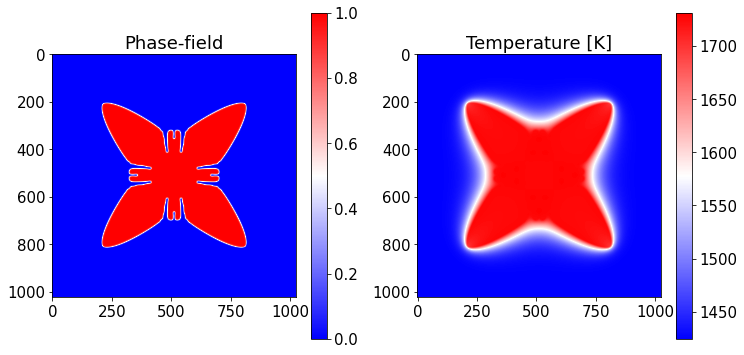

In [ ]:
#initialize PyCuda and get compute capability needed for compilation
drv.init()
context = drv.Device(0).make_context()
devprops = { str(k): v for (k, v) in context.get_device().get_attributes().items() }
cc = str(devprops['COMPUTE_CAPABILITY_MAJOR']) + str(devprops['COMPUTE_CAPABILITY_MINOR'])

#allocate GPU memory
phi = drv.mem_alloc(phi_host.nbytes)
phi_new = drv.mem_alloc(phi_new_host.nbytes)
temp = drv.mem_alloc(temp_host.nbytes)
temp_new = drv.mem_alloc(temp_new_host.nbytes)
grad_phix = drv.mem_alloc(grad_phix_host.nbytes)
grad_phiy = drv.mem_alloc(grad_phiy_host.nbytes)
a2 = drv.mem_alloc(a2_host.nbytes)
lap_temp = drv.mem_alloc(lap_temp_host.nbytes)
lap_phi = drv.mem_alloc(lap_phi_host.nbytes)
ax = drv.mem_alloc(ax_host.nbytes)
ay = drv.mem_alloc(ay_host.nbytes)

#setup thread block dimensions and compile the kernel
threads = (16,16,1)
grid = (int(nx/16), int(ny/16), 1)

block_size_string = "#define block_size_x 16\n#define block_size_y 16\n"
calcgrad = SourceModule(block_size_string+kernel_string1, arch='sm_'+cc).get_function("calcgrad")
timeevol = SourceModule(block_size_string+kernel_string2, arch='sm_'+cc).get_function("timeevol")
print(calcgrad)

#create events for measuring performance
start = drv.Event()
end = drv.Event()

#move the data from the Host (CPU) memory to the Device (GPU) memory
drv.memcpy_htod(phi, phi_host)
drv.memcpy_htod(temp, temp_host)

#call the GPU kernel a 1000 times and measure performance
context.synchronize()
start.record()
start = time()
for nstep in range(stepmax):
    calcgrad(phi, temp, grad_phix, grad_phiy, lap_phi, lap_temp, ax, ay, a2, block=threads, grid=grid)
    timeevol(phi, temp, phi_new, temp_new, ax, ay, a2, grad_phix, grad_phiy, lap_phi, lap_temp, block=threads, grid=grid)
    calcgrad(phi_new, temp_new, grad_phix, grad_phiy, lap_phi, lap_temp, ax, ay, a2, block=threads, grid=grid)
    timeevol(phi_new, temp_new, phi, temp, ax, ay, a2, grad_phix, grad_phiy, lap_phi, lap_temp, block=threads, grid=grid)

end.record()
context.synchronize()

end = time()
print("It takes", (end-start)*1000.0, "ms")

#copy the result data from the Device (GPU) to the Host (CPU) for plotting
phi_result = np.zeros_like(phi_host)
temp_result = np.zeros_like(temp_host)
drv.memcpy_dtoh(phi_result, phi_new)
drv.memcpy_dtoh(temp_result, temp_new)

plt.figure(figsize=(12,6))
plt.rcParams["font.size"] = 15
plt.subplot(121)
plt.imshow(phi_result, cmap="bwr")
plt.title('Phase-field')
plt.colorbar()
plt.subplot(122)
plt.imshow(temp_result, cmap="bwr")
plt.title('Temperature [K]')
plt.colorbar()
plt.show()